In [1]:
# Imports
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
import ir_datasets
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = os.path.dirname(os.path.abspath('.'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import our services
from services.vectorization.tfidf_vectorizer import load_tfidf_model
from services.vectorization.embedding_vectorizer import load_embedding_model
from services.matcher import Matcher
from services.query_processor import QueryProcessor

# Set up plotting style
plt.style.use('default')

print("✓ All imports completed successfully!")
print(f"✓ Project root: {project_root}")

INFO:services.indexing_service:Loading required NLTK resources...


✓ All imports completed successfully!
✓ Project root: c:\Users\Ahmad\Desktop\ir_system_project


In [2]:
# Load documents from database and queries/qrels from evaluation folder
import sqlite3
import pandas as pd
from collections import defaultdict
import os

dataset_name = "antique/test"
print(f"Loading data for: {dataset_name}")

# 1. Load documents from database
print("Loading documents from database...")
db_path = os.path.join(project_root, "data", "ir_documents.db")
print(f"Database path: {db_path}")

conn = sqlite3.connect(db_path)
cursor = conn.cursor()
cursor.execute("SELECT doc_id, text FROM documents WHERE dataset = ?", (dataset_name,))
rows = cursor.fetchall()
conn.close()

documents = {row[0]: row[1] for row in rows}
print(f"Loaded {len(documents)} documents from database")

# 2. Load queries from evaluation folder
print("Loading queries from evaluation folder...")
queries_path = os.path.join(project_root, "evaluation", "antique_test.queries.tsv")
queries_df = pd.read_csv(queries_path, sep='\t', header=None, names=['query_id', 'query_text'])
queries = dict(zip(queries_df['query_id'], queries_df['query_text']))

# 3. Load qrels from evaluation folder
print("Loading qrels from evaluation folder...")
qrels_path = os.path.join(project_root, "evaluation", "antique_test.qrels")
qrels_df = pd.read_csv(qrels_path, sep=' ', header=None, names=['query_id', 'run_id', 'doc_id', 'relevance'])

# Group by query_id, handle NaN values
qrels = {}
for _, row in qrels_df.iterrows():
    query_id = str(row['query_id'])
    doc_id = str(row['doc_id'])
    
    # Handle NaN values in relevance
    if pd.isna(row['relevance']):
        relevance = 0
    else:
        relevance = int(row['relevance'])
    
    if query_id not in qrels:
        qrels[query_id] = {}
    qrels[query_id][doc_id] = relevance

print(f"✓ Loaded: {len(documents)} documents, {len(queries)} queries, {len(qrels)} query-relevance sets")
print(f"Sample query: {list(queries.items())[0]}")
print(f"Sample qrel: {list(qrels.items())[0]}")

Loading data for: antique/test
Loading documents from database...
Database path: c:\Users\Ahmad\Desktop\ir_system_project\data\ir_documents.db
Loaded 403666 documents from database
Loading queries from evaluation folder...
Loading qrels from evaluation folder...
✓ Loaded: 403666 documents, 200 queries, 200 query-relevance sets
Sample query: (3990512, 'how can we get concentration onsomething?')
Sample qrel: ('1964316', {'1964316_5': 4, '1674088_11': 1, '1218838_13': 2, '1519022_15': 2, '3059341_5': 2, '4126855_1': 2, '2434719_9': 2, '3786452_1': 2, '1964316_3': 4, '1964316_2': 4, '767911_0': 2, '1964316_0': 4, '1964316_1': 3, '1964316_4': 3, '1248144_1': 2, '2768257_0': 2, '1519022_3': 2, '2245059_0': 2, '1013722_5': 2, '650233_14': 2, '2305171_0': 2, '3435824_3': 2, '636973_2': 1, '1724160_7': 2, '3592532_6': 2, '636973_1': 1, '1148987_10': 2, '2787567_1': 2, '647686_0': 2, '369616_4': 4, '1759521_19': 3, '2929011_0': 4, '1810312_4': 2})


In [4]:
# Change to project root directory
import os
os.chdir(project_root)
print(f"Changed to project root: {os.getcwd()}")

# Load Hybrid models and vectors
print("Loading Hybrid models and vectors...")

# Load TF-IDF model and vectors
try:
    print("Loading TF-IDF model...")
    tfidf_vectorizer, tfidf_matrix, tfidf_doc_ids = load_tfidf_model(dataset_name)
    print(f"✓ TF-IDF model loaded successfully!")
    print(f"- Matrix shape: {tfidf_matrix.shape}")
    print(f"- Number of documents: {len(tfidf_doc_ids)}")
    print(f"- Vectorizer features: {len(tfidf_vectorizer.get_feature_names_out())}")
except Exception as e:
    print(f"❌ Error loading TF-IDF: {e}")
    tfidf_vectorizer = None
    tfidf_matrix = None
    tfidf_doc_ids = None

# Load Embedding model and vectors
try:
    print("Loading Embedding model...")
    embedding_model, embedding_vectors, embedding_doc_ids = load_embedding_model(dataset_name)
    print(f"✓ Embedding model loaded successfully!")
    print(f"- Vectors shape: {embedding_vectors.shape}")
    print(f"- Number of documents: {len(embedding_doc_ids)}")
    print(f"- Embedding dimension: {embedding_vectors.shape[1]}")
except Exception as e:
    print(f"❌ Error loading Embedding: {e}")
    embedding_model = None
    embedding_vectors = None
    embedding_doc_ids = None

# Check if both models are loaded
if tfidf_vectorizer is None or embedding_model is None:
    print("❌ Cannot proceed with hybrid evaluation - missing models")
else:
    print("✓ Both models loaded successfully! Ready for hybrid evaluation.")
    
    # Verify document ID matching
    if tfidf_doc_ids == embedding_doc_ids:
        print("✓ Document IDs match between TF-IDF and Embedding models")
    else:
        print("⚠️ Warning: Document IDs don't match between models")
        print(f"TF-IDF doc_ids: {len(tfidf_doc_ids)}")
        print(f"Embedding doc_ids: {len(embedding_doc_ids)}")

Changed to project root: c:\Users\Ahmad\Desktop\ir_system_project
Loading Hybrid models and vectors...
Loading TF-IDF model...
[✓] TF-IDF model loaded: antique/test
✓ TF-IDF model loaded successfully!
- Matrix shape: (403666, 274045)
- Number of documents: 403666
- Vectorizer features: 274045
Loading Embedding model...
[⏳] Loading model from: models\antique_test_embedding_model.joblib
[⏳] Loading vectors from: vectors\antique_test_embedding_vectors.joblib
[✓] Model and vectors loaded successfully
✓ Embedding model loaded successfully!
- Vectors shape: (403666, 384)
- Number of documents: 403666
- Embedding dimension: 384
✓ Both models loaded successfully! Ready for hybrid evaluation.
✓ Document IDs match between TF-IDF and Embedding models


In [6]:
# Run Hybrid evaluation on all queries
print("Running Hybrid evaluation on all queries...")

# Initialize results storage
hybrid_results = {}
total_queries = len(queries)
print(f"Evaluating {total_queries} queries...")

# Process each query
for i, (query_id, query_text) in enumerate(queries.items(), 1):
    if i % 20 == 0:  # Progress update every 20 queries
        print(f"Processing query {i}/{total_queries}...")
    
    try:
        # Get matching results using Hybrid Matcher
        results = matcher.match(query_text, top_k=10)
        
        # Store results
        hybrid_results[query_id] = {
            'query_text': query_text,
            'results': results,  # List of (doc_idx, score) tuples
            'doc_ids': [doc_idx for doc_idx, _ in results],
            'scores': [score for _, score in results]
        }
        
    except Exception as e:
        print(f"Error processing query {query_id}: {e}")
        hybrid_results[query_id] = {
            'query_text': query_text,
            'results': [],
            'doc_ids': [],
            'scores': []
        }

print(f"✓ Hybrid evaluation completed!")
print(f"✓ Processed {len(hybrid_results)} queries")
print(f"✓ Results stored for {len([r for r in hybrid_results.values() if r['results']])} successful queries")

# Show sample results
sample_query_id = list(hybrid_results.keys())[0]
sample_result = hybrid_results[sample_query_id]
print(f"\nSample results for query {sample_query_id}:")
print(f"Query: {sample_result['query_text']}")
print(f"Top 5 results:")
for i, (doc_idx, score) in enumerate(sample_result['results'][:5]):
    print(f"  {i+1}. Doc {doc_idx}: score {score:.4f}")

Running Hybrid evaluation on all queries...
Evaluating 200 queries...


Batches: 100%|██████████| 1/1 [00:00<00:00, 22.98it/s]


Processing query 20/200...


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.95it/s]


Processing query 40/200...


Batches: 100%|██████████| 1/1 [00:00<00:00, 27.10it/s]


Processing query 60/200...


Batches: 100%|██████████| 1/1 [00:00<00:00, 20.05it/s]


Processing query 80/200...


Batches: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Processing query 100/200...


Batches: 100%|██████████| 1/1 [00:00<00:00, 20.66it/s]


Processing query 120/200...


Batches: 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


Processing query 140/200...


Batches: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s]


Processing query 160/200...


Batches: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Processing query 180/200...


Batches: 100%|██████████| 1/1 [00:00<00:00, 23.87it/s]


Processing query 200/200...


Batches: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


✓ Hybrid evaluation completed!
✓ Processed 200 queries
✓ Results stored for 200 successful queries

Sample results for query 3990512:
Query: how can we get concentration onsomething?
Top 5 results:
  1. Doc 256467: score 0.7834
  2. Doc 288355: score 0.7833
  3. Doc 146730: score 0.6397
  4. Doc 288350: score 0.6089
  5. Doc 301175: score 0.5354


In [11]:
# Calculate metrics for Hybrid evaluation (following TF-IDF/Embedding pattern)
print("Calculating metrics for Hybrid evaluation...")

# Initialize metrics storage
hybrid_metrics = {
    'precision_at_10': [],
    'recall_at_10': [],
    'mrr': [],
    'map': []
}

# Process each query
for query_id, result in hybrid_results.items():
    if 'error' in result:
        continue  # Skip failed queries
    
    # Convert query_id to string for comparison
    str_query_id = str(query_id)
    if str_query_id not in qrels:
        continue  # Skip queries without qrels
    
    query_text = result['query_text']
    results = result['results']  # List of (doc_idx, score) tuples
    
    # Get relevant documents for this query
    relevant_docs = qrels[str_query_id]
    print(f"Query {query_id}: {len(relevant_docs)} relevant docs")
    
    if not relevant_docs:
        continue  # Skip queries with no relevant documents
    
    # Convert results to document IDs using tfidf_doc_ids
    retrieved_doc_ids = []
    for doc_idx, score in results:
        if doc_idx < len(tfidf_doc_ids):
            retrieved_doc_ids.append(tfidf_doc_ids[doc_idx])
        else:
            retrieved_doc_ids.append(f"doc_{doc_idx}")
    
    # Calculate Precision@10
    top_10_docs = retrieved_doc_ids[:10]
    relevant_in_top_10 = sum(1 for doc_id in top_10_docs if doc_id in relevant_docs)
    precision_at_10 = relevant_in_top_10 / 10 if top_10_docs else 0
    hybrid_metrics['precision_at_10'].append(precision_at_10)
    
    # Calculate Recall@10
    total_relevant = len(relevant_docs)
    recall_at_10 = relevant_in_top_10 / total_relevant if total_relevant > 0 else 0
    hybrid_metrics['recall_at_10'].append(recall_at_10)
    
    # Calculate MRR (Mean Reciprocal Rank)
    mrr = 0
    for rank, doc_id in enumerate(retrieved_doc_ids, 1):
        if doc_id in relevant_docs:
            mrr = 1.0 / rank
            break
    hybrid_metrics['mrr'].append(mrr)
    
    # Calculate MAP (Mean Average Precision)
    ap = 0
    relevant_found = 0
    for rank, doc_id in enumerate(retrieved_doc_ids, 1):
        if doc_id in relevant_docs:
            relevant_found += 1
            ap += relevant_found / rank
    ap = ap / total_relevant if total_relevant > 0 else 0
    hybrid_metrics['map'].append(ap)

# Calculate average metrics
if hybrid_metrics['precision_at_10']:
    avg_precision_at_10 = np.mean(hybrid_metrics['precision_at_10'])
    avg_recall_at_10 = np.mean(hybrid_metrics['recall_at_10'])
    avg_mrr = np.mean(hybrid_metrics['mrr'])
    avg_map = np.mean(hybrid_metrics['map'])
    
    print(f"\nHybrid Evaluation Results:")
    print(f"Precision@10: {avg_precision_at_10:.4f}")
    print(f"Recall@10: {avg_recall_at_10:.4f}")
    print(f"MRR: {avg_mrr:.4f}")
    print(f"MAP: {avg_map:.4f}")
    
    # Store results for comparison
    hybrid_final_results = {
        'method': 'hybrid',
        'precision_at_10': avg_precision_at_10,
        'recall_at_10': avg_recall_at_10,
        'mrr': avg_mrr,
        'map': avg_map,
        'detailed_metrics': hybrid_metrics
    }
    
    print(f"\n✓ Hybrid evaluation metrics calculated and stored successfully!")
else:
    print("\n❌ No metrics calculated - check qrels data")

Calculating metrics for Hybrid evaluation...
Query 3990512: 36 relevant docs
Query 714612: 30 relevant docs
Query 2528767: 23 relevant docs
Query 821387: 41 relevant docs
Query 1880028: 31 relevant docs
Query 4448097: 36 relevant docs
Query 1287437: 33 relevant docs
Query 2956570: 29 relevant docs
Query 1351675: 31 relevant docs
Query 1783010: 18 relevant docs
Query 2799913: 37 relevant docs
Query 2142044: 23 relevant docs
Query 707303: 25 relevant docs
Query 676028: 31 relevant docs
Query 2484180: 36 relevant docs
Query 2307305: 31 relevant docs
Query 2814599: 23 relevant docs
Query 3369088: 44 relevant docs
Query 1702151: 34 relevant docs
Query 851124: 30 relevant docs
Query 3698636: 40 relevant docs
Query 1844896: 30 relevant docs
Query 2290758: 37 relevant docs
Query 143833: 26 relevant docs
Query 3910925: 40 relevant docs
Query 2643507: 34 relevant docs
Query 1502604: 34 relevant docs
Query 4283542: 29 relevant docs
Query 3554263: 34 relevant docs
Query 3313308: 40 relevant docs
Q

Creating visualizations and saving results...


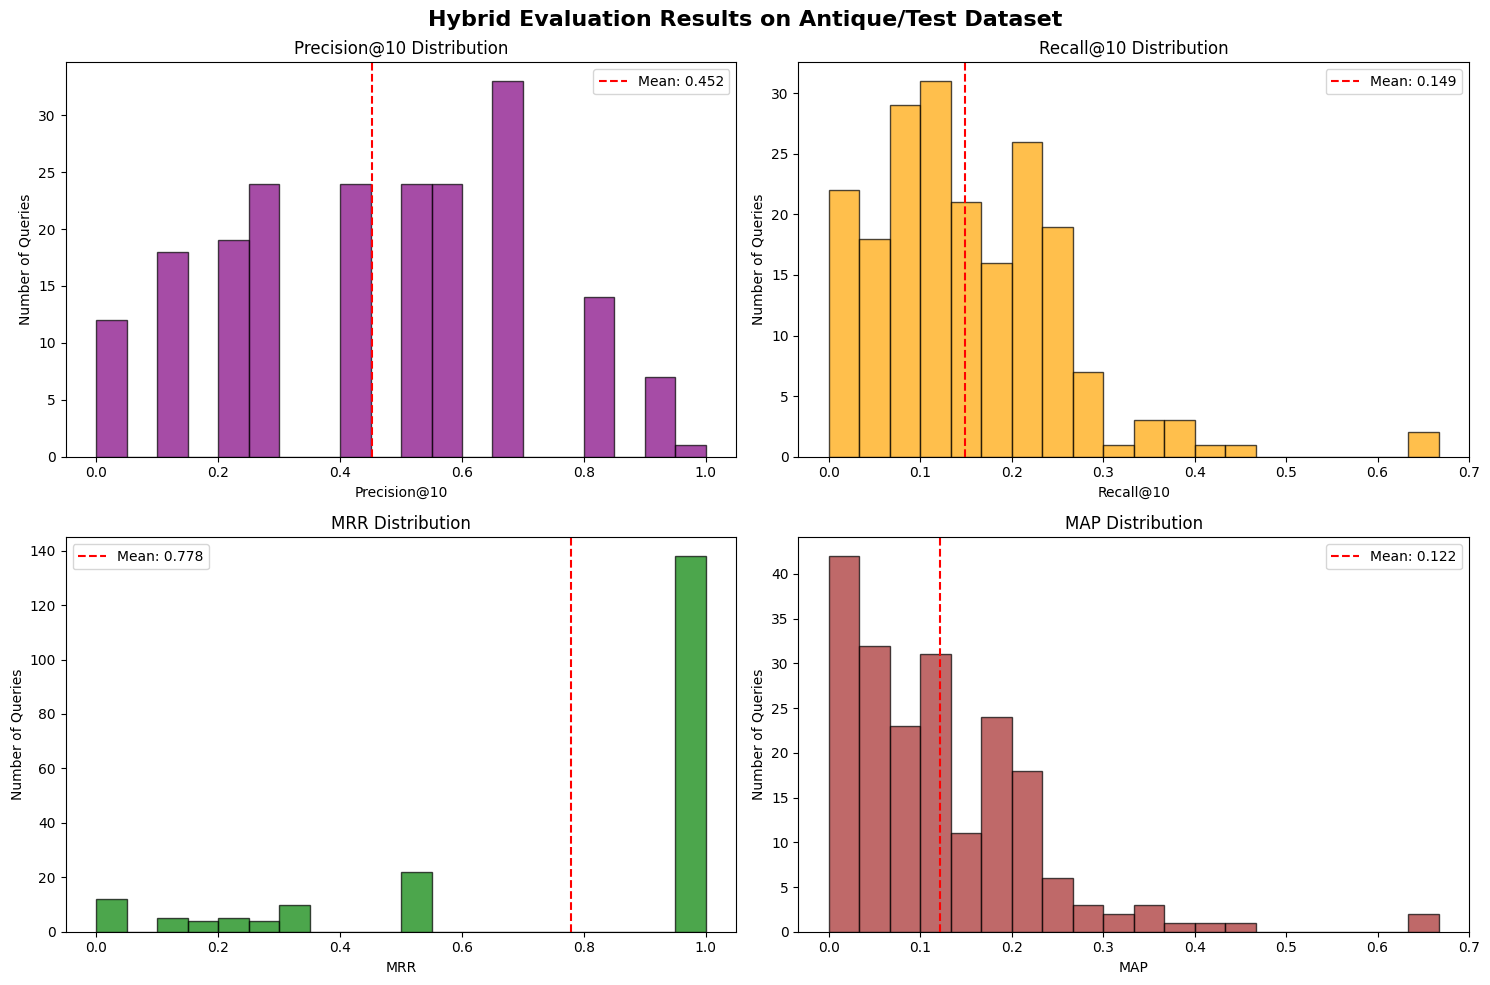

✓ Results saved to: c:\Users\Ahmad\Desktop\ir_system_project\evaluation\hybrid_antique_results.json

📊 Hybrid Evaluation Summary:
Dataset: antique/test
Method: Hybrid (TF-IDF + Embedding)
Total Queries: 200
Queries with Metrics: 200
Average Precision@10: 0.4520
Average Recall@10: 0.1492
Average MRR: 0.7784
Average MAP: 0.1217

✅ Hybrid evaluation completed successfully!


In [12]:
# Plot results and save metrics
import matplotlib.pyplot as plt
import json
from datetime import datetime

print("Creating visualizations and saving results...")

# Create figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Hybrid Evaluation Results on Antique/Test Dataset', fontsize=16, fontweight='bold')

# 1. Precision@10 distribution
ax1.hist(hybrid_metrics['precision_at_10'], bins=20, alpha=0.7, color='purple', edgecolor='black')
ax1.set_title('Precision@10 Distribution')
ax1.set_xlabel('Precision@10')
ax1.set_ylabel('Number of Queries')
ax1.axvline(hybrid_final_results['precision_at_10'], color='red', linestyle='--', 
            label=f'Mean: {hybrid_final_results["precision_at_10"]:.3f}')
ax1.legend()

# 2. Recall@10 distribution
ax2.hist(hybrid_metrics['recall_at_10'], bins=20, alpha=0.7, color='orange', edgecolor='black')
ax2.set_title('Recall@10 Distribution')
ax2.set_xlabel('Recall@10')
ax2.set_ylabel('Number of Queries')
ax2.axvline(hybrid_final_results['recall_at_10'], color='red', linestyle='--', 
            label=f'Mean: {hybrid_final_results["recall_at_10"]:.3f}')
ax2.legend()

# 3. MRR distribution
ax3.hist(hybrid_metrics['mrr'], bins=20, alpha=0.7, color='green', edgecolor='black')
ax3.set_title('MRR Distribution')
ax3.set_xlabel('MRR')
ax3.set_ylabel('Number of Queries')
ax3.axvline(hybrid_final_results['mrr'], color='red', linestyle='--', 
            label=f'Mean: {hybrid_final_results["mrr"]:.3f}')
ax3.legend()

# 4. MAP distribution
ax4.hist(hybrid_metrics['map'], bins=20, alpha=0.7, color='brown', edgecolor='black')
ax4.set_title('MAP Distribution')
ax4.set_xlabel('MAP')
ax4.set_ylabel('Number of Queries')
ax4.axvline(hybrid_final_results['map'], color='red', linestyle='--', 
            label=f'Mean: {hybrid_final_results["map"]:.3f}')
ax4.legend()

plt.tight_layout()
plt.show()

# Save results
results_summary = {
    'dataset': 'antique/test',
    'method': 'hybrid',
    'evaluation_date': datetime.now().isoformat(),
    'total_queries': len(queries),
    'queries_with_metrics': len(hybrid_metrics['precision_at_10']),
    'average_metrics': {
        'avg_precision_at_10': hybrid_final_results['precision_at_10'],
        'avg_recall_at_10': hybrid_final_results['recall_at_10'],
        'avg_mrr': hybrid_final_results['mrr'],
        'avg_map': hybrid_final_results['map']
    },
    'detailed_metrics': {
        'precision_at_10': hybrid_metrics['precision_at_10'],
        'recall_at_10': hybrid_metrics['recall_at_10'],
        'mrr': hybrid_metrics['mrr'],
        'map': hybrid_metrics['map']
    }
}

# Save to JSON file
results_file = os.path.join(project_root, "evaluation", "hybrid_antique_results.json")
with open(results_file, 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, indent=2, ensure_ascii=False)

print(f"✓ Results saved to: {results_file}")

# Print summary
print(f"\n📊 Hybrid Evaluation Summary:")
print(f"Dataset: antique/test")
print(f"Method: Hybrid (TF-IDF + Embedding)")
print(f"Total Queries: {len(queries)}")
print(f"Queries with Metrics: {len(hybrid_metrics['precision_at_10'])}")
print(f"Average Precision@10: {hybrid_final_results['precision_at_10']:.4f}")
print(f"Average Recall@10: {hybrid_final_results['recall_at_10']:.4f}")
print(f"Average MRR: {hybrid_final_results['mrr']:.4f}")
print(f"Average MAP: {hybrid_final_results['map']:.4f}")

print(f"\n✅ Hybrid evaluation completed successfully!")